# baseline NCA
基本caadria版本的cfd nca 

- 整張圖訓練 low resolution
- 先完成overfit

In [131]:
# 1. 標準庫
import sys
import os
import io
import json
import glob

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML

# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 共享 core_utils 函式庫導入
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)

from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji,   # 載入 emoji 圖像
    load_cfd_npy
)

from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

from core_utils.ops_tf_np import (
    to_rgb,
    to_rgba,
    to_alpha,
    crop_and_resize,
    get_random_cfd_slices,
    get_random_cfd_slices_pair
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

# Global Params

In [132]:
#@title Cellular Automata Parameters
CHANNEL_N = 24        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 64
BATCH_SIZE = 8
POOL_SIZE = 256
ITER_STEP_RANGE = [8, 16]  # Range of iterations per step

USE_PATTERN_POOL = True
DAMAGE_N = 3

# load data

(12, 30, 161, 161, 8)
(41, 161, 161, 4)


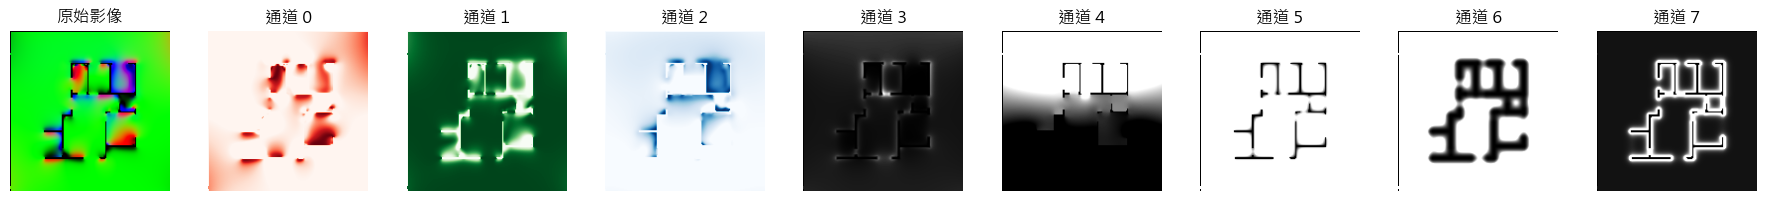

In [133]:
# 載入檔案
dynamic_fields = load_cfd_npy('../dataset/dynamic_fields.npy')
static_fields = load_cfd_npy('../dataset/static_fields.npy')[..., 3:] # 去除絕對座標XYZ

dynamic_fields = dynamic_fields[:,1:31,:,:,:]  # 只保留 z=1 到 z=30 的動態場
print(dynamic_fields.shape)
print(static_fields.shape)
# for z in range(dynamic_fields.shape[1]):
#     print(f"z={z}")
plt_HWC_split_channels(dynamic_fields[0,16,:,:,:], histogram=False, max_channels=None)
# plt_HWC_split_channels(dynamic_fields[-1,16,:,:,:], histogram=False, max_channels=None)
# plt_HWC_split_channels(static_fields[16], histogram=False, max_channels=None)

# build Model

## func

## model

In [134]:


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N):
    super().__init__()
    self.channel_n = channel_n
    self.dmodel = tf.keras.Sequential([
          layers.Conv2D(128, 1, activation=tf.nn.relu),
          layers.Conv2D(128, 1, activation=tf.nn.relu),
          layers.Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, n_times=1):
    for _ in range(n_times):
      x = self.forward_pass(x)
    return x
  
  @tf.function
  def forward_pass(self, x, angle=0.0):
      # 保留原始的第 8-12 通道（注意 Python 為 0-index）
      preserved = x[..., 8:13]  # shape: (b, h, w, 4)
      
      y = self.perceive(x, angle)
      dx = self.dmodel(y)
      x += dx

      # 將第 8-12 通道還原
      x = tf.concat([x[..., :8], preserved, x[..., 13:]], axis=-1)
      return x


CAModel().dmodel.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_194 (Conv2D)         (1, 3, 3, 128)            9344      
                                                                 
 conv2d_195 (Conv2D)         (1, 3, 3, 128)            16512     
                                                                 
 conv2d_196 (Conv2D)         (1, 3, 3, 24)             3096      
                                                                 
Total params: 28,952
Trainable params: 28,952
Non-trainable params: 0
_________________________________________________________________


# Training

## make_circle_masks

In [135]:
@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask


## loss_fn

In [136]:
def loss_f(x, target=None):
  return tf.reduce_mean(tf.square(x[...,:8]-target[...,:8]), [-3, -2, -1])


In [137]:
def get_U_embed_img(x_tensor, channels=[0,1,2,11]):
    return tf.gather(x_tensor, channels, axis=-1)

## get t0 and seed

In [138]:
def get_seed(t0_tensor):
    seed = tf.zeros_like(t0_tensor, dtype=tf.float32).numpy()
    seed[..., 8:12] = t0_tensor[..., 8:12]
    seed[..., :8] = t0_tensor[..., 11:12]
    return seed


def single_sample(dynamic_fields, static_fields,xy_size=None):
    T, Z, Y, X, C_dyn = dynamic_fields.shape
    _, _, _, C_static = static_fields.shape
    h = Y if xy_size is None else xy_size[0]
    w = X if xy_size is None else xy_size[1]

    # 時間與空間隨機選取
    t = 0 
    z = tf.random.uniform([], 0, Z, dtype=tf.int32)
    sy = tf.constant(0) if h == Y else tf.random.uniform([], 0, Y - h + 1, dtype=tf.int32)
    sx = tf.constant(0) if w == X else tf.random.uniform([], 0, X - w + 1, dtype=tf.int32)

    # 擷取資料
    dyn_t = dynamic_fields[t, z, sy:sy+h, sx:sx+w, :]
    sta = static_fields[z, sy:sy+h, sx:sx+w, :]

    t0_slice = tf.concat([sta, dyn_t], axis=-1)

    return t0_slice

def get_t0(dynamic_fields, static_fields, count, target_size=(TARGET_SIZE,TARGET_SIZE), crop_xy_size=None, channel_n=CHANNEL_N):
    
    t0_slices = tf.map_fn(
        lambda _: single_sample(dynamic_fields, static_fields, crop_xy_size),
        tf.range(count),
        dtype=tf.float32
    )
    t0_slices = tf.reverse(t0_slices, axis=[1])

    t0_slices


    t0_slices = crop_and_resize(t0_slices, target_size, crop_size=2)
    
    hidden_channels = tf.zeros((count, t0_slices.shape[1], t0_slices.shape[2], channel_n - 12), dtype=tf.float32)


    return tf.concat([t0_slices[..., 4:], t0_slices[..., :4], hidden_channels], axis=-1)

## init train

target shape: (8, 64, 64, 24)


  plt.tight_layout()

  fig.canvas.print_figure(bytes_io, **kw)



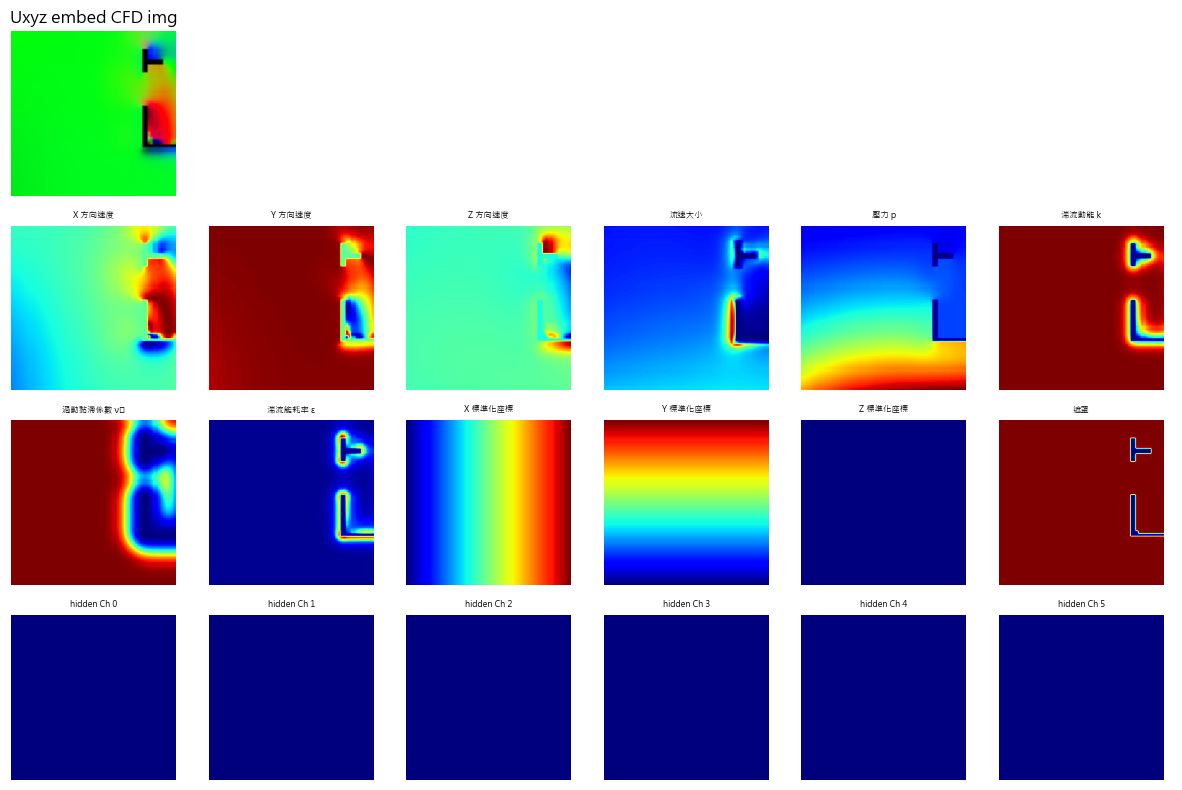

seed shape: (8, 64, 64, 24)


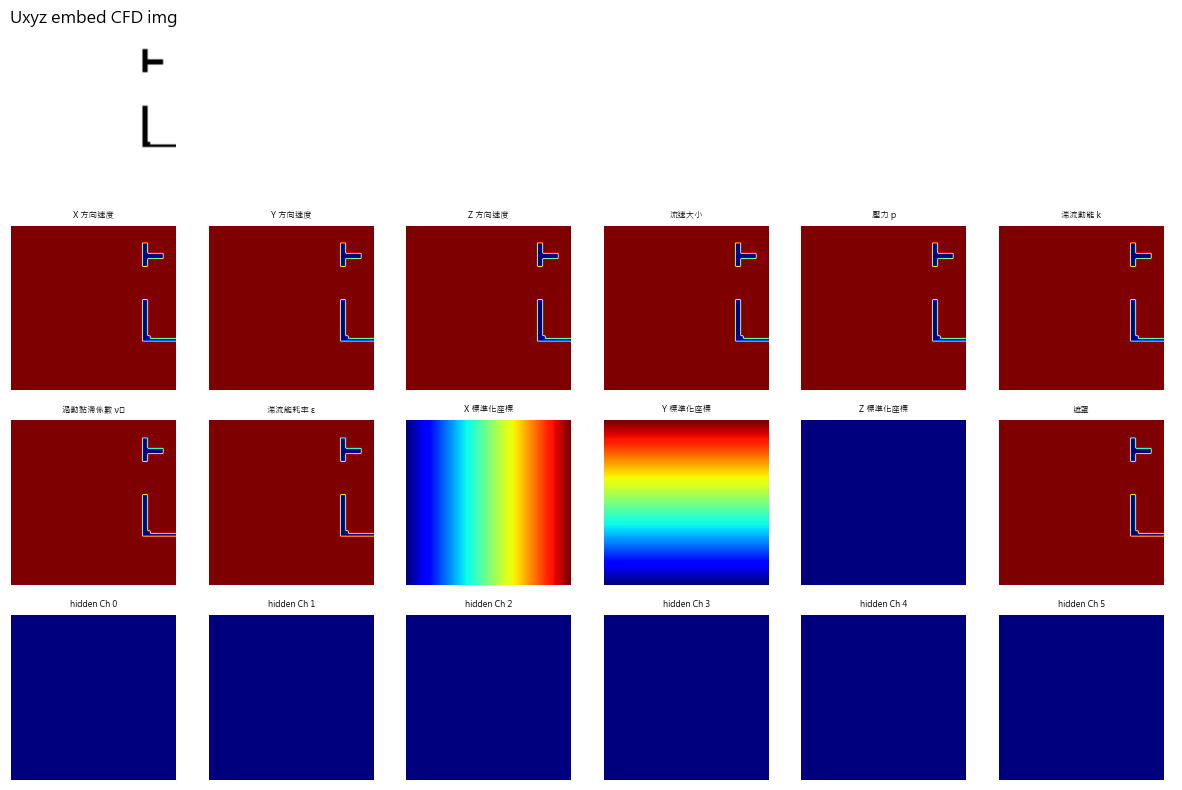

In [139]:
target = get_t0(dynamic_fields, static_fields, BATCH_SIZE, crop_xy_size=(TARGET_SIZE, TARGET_SIZE))
print("target shape:", target.shape)
plt_CFD_channels(target[0])

seed = get_seed(target)
print("seed shape:", seed.shape)
plt_CFD_channels(seed[0])

# 取得 padding 後影像尺寸
height, width = target.shape[:2]

# 建立 NCA 模型實例
ca = CAModel()

# 設定學習率與階梯衰減學習率調度器
initial_lr = 2e-3
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000], values=[initial_lr, initial_lr * 0.1]
)


# 建立優化器，Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 初始損失（以種子推論一次損失）
loss0 = loss_f(seed, target).numpy()

# 編譯模型以便儲存完整訓練資訊
ca.compile(optimizer=optimizer, loss=loss_f)

# 建立 SamplePool，儲存多個種子作為訓練樣本池
data={
    'x': np.repeat(seed[None, ...], POOL_SIZE, axis=0)
}
pool = SamplePool(data)


## train step

In [140]:
@tf.function
def train_step(x, target, model, loss_fn, optimizer):
  iter_n = tf.random.uniform([], ITER_STEP_RANGE[0],ITER_STEP_RANGE[1], tf.int32)
  with tf.GradientTape() as g:
    x = model(x, n_times=iter_n)
    loss = tf.reduce_mean(loss_fn(x, target))
  grads = g.gradient(loss, model.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  optimizer.apply_gradients(zip(grads, model.weights))
  return x, loss

## run train

batch (before/after):


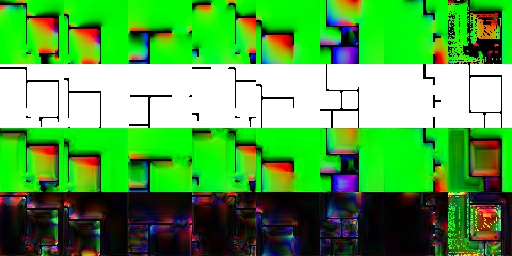

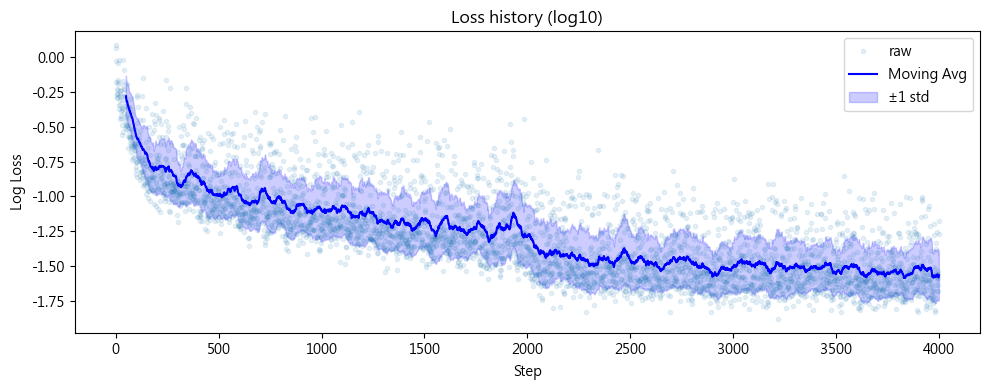

INFO:tensorflow:Assets written to: ../outputs/E3-1_CFDInitNCA_patchSize/saved_model/4000\assets


INFO:tensorflow:Assets written to: ../outputs/E3-1_CFDInitNCA_patchSize/saved_model/4000\assets
  plt.tight_layout()

  fig.canvas.print_figure(bytes_io, **kw)



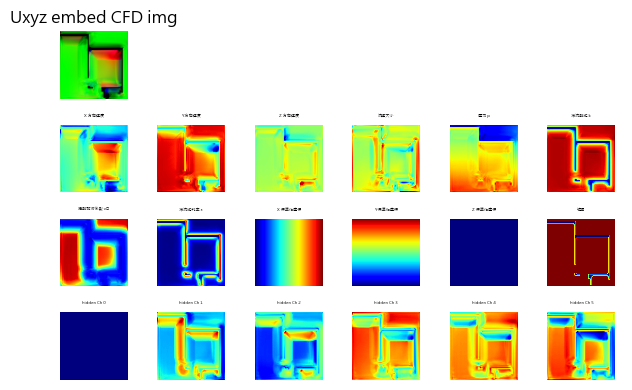

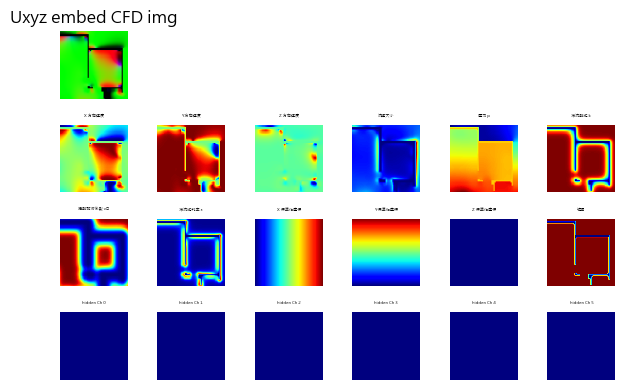

 step: 4001, log10(loss): -1.268

In [141]:
loss_log=[]
OUT_PATH = '../outputs/E3-1_CFDInitNCA_patchSize'
EPOCHS=4000+1

for i in range(EPOCHS):
  # plt_CFD_channels(seed[0])
  target = get_t0(dynamic_fields, static_fields,BATCH_SIZE, crop_xy_size=(TARGET_SIZE, TARGET_SIZE))
  x0 = get_seed(target)
  # plt_CFD_channels(target[0])


  x, loss = train_step(x0, target, ca, loss_f, optimizer)


  step_i = len(loss_log)
  loss_log.append(loss.numpy())
 


  if step_i%100 == 0 and step_i > 0:
    clear_output()
    viz_batch([target,x0, x, tf.abs(x-target)], step_i, output_path=f'{OUT_PATH}/batch')
    if step_i == EPOCHS+1:
      viz_loss(loss_log, save_path=f'{OUT_PATH}')
    else:
      viz_loss(loss_log)
    ca.save(f'{OUT_PATH}/saved_model/{step_i}')
    plt_CFD_channels(x[0],figsize=1)
    plt_CFD_channels(target[0],figsize=1)
    
  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')


# Figures

In [142]:
models = []
for i in [100, 500, 1000, 2000, 4000]:
  loaded_ca = tf.keras.models.load_model(f'{OUT_PATH}/saved_model/{i}',
                                         custom_objects={'loss_f': loss_f, 'CAModel': CAModel, 'to_rgba': to_rgba})
  models.append(loaded_ca)

out_fn = f'{OUT_PATH}/video/trained_for_differnt_steps.mp4'

# 自動建立資料夾
out_dir = os.path.dirname(out_fn)
os.makedirs(out_dir, exist_ok=True)

target = get_t0(dynamic_fields, static_fields,len(models))
x = get_seed(target)

with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(ITER_STEP_RANGE[1]):
    # if i%50==0:
    #     damage = 1.0-make_circle_masks(DAMAGE_N, h=h, w=w).numpy()[..., None]
    #     x[-DAMAGE_N:] *= damage
    vis = np.hstack(x[...,:3])
    vid.add(zoom(vis, 2))
    for loaded_ca, xk in zip(models, x):
      xk[:] = loaded_ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

  6%|▋         | 1/16 [00:00<00:06,  2.38it/s]


OSError: [Errno 22] Invalid argument

MoviePy error: FFMPEG encountered the following error while writing file ../outputs/E3-1_CFDInitNCA_patchSize/video/trained_for_differnt_steps.mp4:

 b'../outputs/E3-1_CFDInitNCA_patchSize/video/trained_for_differnt_steps.mp4: Permission denied\r\n'

In [ ]:
#@title Training Progress (Batches)
video_path = f'{OUT_PATH}/video/batches.mp4'
frames = sorted(glob.glob(f'{OUT_PATH}/batch/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile(video_path)
mvp.ipython_display(video_path)

Moviepy - Building video ../outputs/E3-1_CFDInitNCA_patchSize/video/batches.mp4.
Moviepy - Writing video ../outputs/E3-1_CFDInitNCA_patchSize/video/batches.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/E3-1_CFDInitNCA_patchSize/video/batches.mp4
